# Integration of SIMPLE on spatial proteomics datasets.

## 1. load packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import SIMPLE

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/lvyz/miniconda3/envs/SIMPLE_env/lib/R"
os.environ['R_USER'] = "/home/lvyz/miniconda3/envs/SIMPLE_env/lib/python3.8/site-packages/rpy2"


import anndata as ad
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# font settings
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# seed setting
seed=666
SIMPLE.utils.fix_randomseed(seed)

## 2. load data and construct spatial neighborhood graph

In [ ]:
adata_all = []
# mouse_spleen: Mouse_Spleen1, Mouse_Spleen2
slice_ids = ['Mouse_Thymus_1','Mouse_Thymus_2','Mouse_Thymus_3']
edge_index_list = []
offset = 0
num_nodes_per_slice = []
for slice_id in slice_ids:
    print(slice_id)
    adata = sc.read_h5ad(f"/Data/lvyz/data/protein/{slice_id}/adata_ADT.h5ad")
    print(adata)

    # preprocess
    adata.obs_names = [x+'_'+slice_id for x in adata.obs_names]
    print(adata.var_names)
    SIMPLE.utils.clr_normalize_each_cell(adata)
    
    if isinstance(adata.X, np.ndarray):
        adata.X = csr_matrix(adata.X)
    # Construct the spatial neighborhood graph for each slice
    SIMPLE.Cal_Spatial_Net(adata,k_cutoff=6)
    edge_index = adata.uns['edge_index']
    edge_index = edge_index + offset
    offset += adata.n_obs
    edge_index_list.append(edge_index)

    print(adata)
    adata_all.append(adata)
    
adata_concat = ad.concat(adata_all, label="batch", keys=slice_ids)
adata_concat.obs["batch"] = adata_concat.obs["batch"].astype('category')

# Concat the spatial neighborhood graph for multiple slices
edge_index_concat = np.hstack(edge_index_list)
adata_concat.uns['edge_index'] = edge_index_concat
print(adata_concat)


Dataset4_Mouse_Thymus2
AnnData object with n_obs × n_vars = 4253 × 19
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'
Index(['mouse_CD5', 'mouse_CD68', 'mouse_CD4', 'mouse_rat_CD29', 'mouse_CD8a',
       'mouse_CD3', 'mouse_human_CD44', 'mouse_rat_human_CD27', 'mouse_CD90_2',
       'mouse_CD11c', 'mouse_CD31', 'mouse_F4_80', 'mouse_human_CD45R_B220',
       'Rat_IgG2a', 'mouse_human_CD11b', 'mouse_CD19', 'Mouse_IgG2a',
       'mouse_Siglec_H', 'mouse_CD169_Siglec-1'],
      dtype='object')
------------Calculating spatial neighborhood graph------------
AnnData object with n_obs × n_vars = 4253 × 19
    obs: 'orig.ident', 'x', 'y'
    uns: 'edge_index'
    obsm: 'spatial'
Dataset5_Mouse_Thymus3
AnnData object with n_obs × n_vars = 4646 × 19
    obs: 'orig.ident', 'x', 'y'
    obsm: 'spatial'
Index(['mouse_CD5', 'mouse_CD4', 'mouse_CD68', 'mouse_rat_CD29', 'mouse_CD8a',
       'mouse_CD3', 'mouse_human_CD44', 'mouse_CD90_2', 'mouse_rat_human_CD27',
       'mouse_CD11c', 'mouse_CD31',

## 3. train SIMPLE

In [3]:
adata_concat=SIMPLE.train_SIMPLE(adata_concat,hidden_dims=16,device=used_device,random_seed=seed)

Pretraining...


100%|██████████| 500/500 [00:14<00:00, 34.20it/s]


Training SIMPLE...


100%|██████████| 500/500 [01:00<00:00,  8.29it/s]


## 4. clustering

In [4]:
SIMPLE.utils.mclust_R(adata_concat, num_cluster=9,random_seed=seed,refinement=False)

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

  |======================================================================| 100%


AnnData object with n_obs × n_vars = 13127 × 19
    obs: 'orig.ident', 'x', 'y', 'batch', 'mclust'
    uns: 'edge_index'
    obsm: 'spatial', 'simgcl', 'SIMPLE'

## 5. plot UMAP

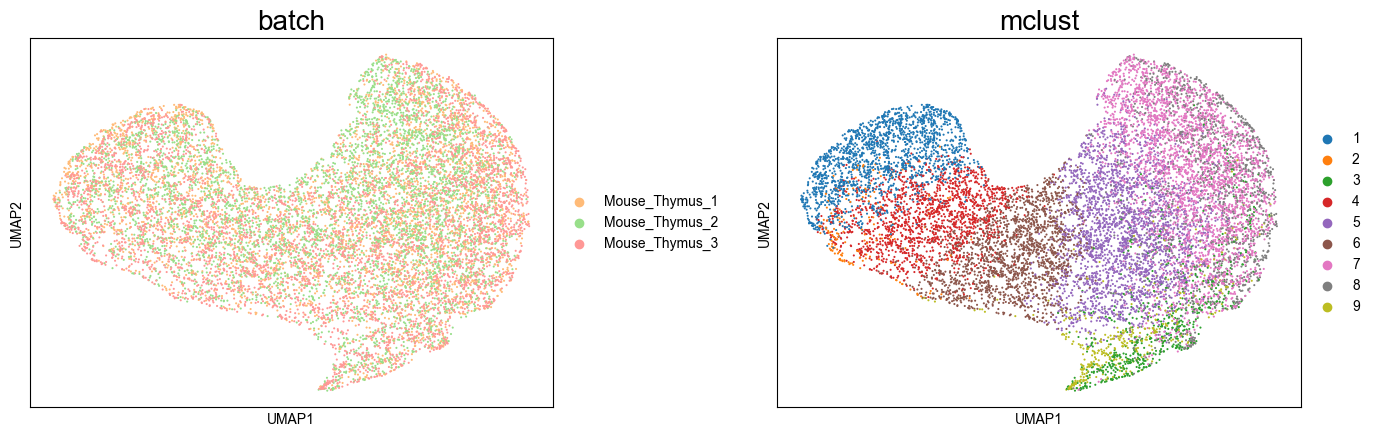

In [ ]:
sc.pp.neighbors(adata_concat, use_rep='SIMPLE', random_state=seed)
sc.tl.umap(adata_concat, random_state=seed)
adata_concat.obs['mclust'] = adata_concat.obs['mclust'].astype(int).astype('category')

color = ['#ffbb78', '#98df8a', '#ff9896']
color_dict = dict(zip(slice_ids, color))
adata_concat.uns['batch_colors'] = [color_dict[x] for x in adata_concat.obs.batch.cat.categories]
axs=sc.pl.umap(adata_concat, color=['batch', 'mclust'], ncols=2,wspace=0.3, show=False)
for ax in axs:
    ax.set_title(ax.get_title(),fontsize=20)
plt.show()
plt.close()

## 6. visualization

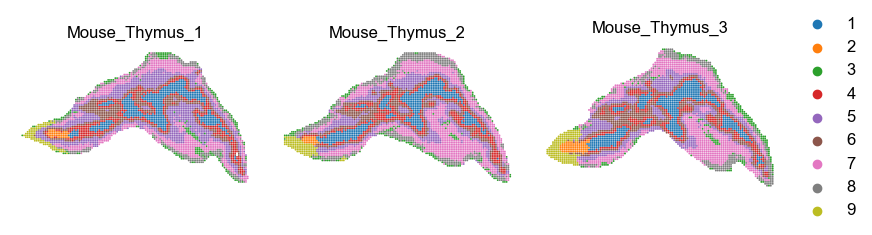

In [ ]:
adata_list = []
for id in slice_ids:
    adata_list.append(adata_concat[adata_concat.obs['batch'] == id])

spot_size = 100
title_size = 12
adata_list[2].obsm["spatial"] = adata_list[2].obsm["spatial"][:, [1, 0]]
adata_list[2].obsm["spatial"][:, 0] = adata_list[2].obsm["spatial"][:, 0].max() - adata_list[2].obsm["spatial"][:, 0]
fig, ax = plt.subplots(1, len(slice_ids), figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for i in range(len(slice_ids)):
    if i <len(slice_ids)-1:
        _sc=sc.pl.spatial(adata_list[i], img_key=None, color=['mclust'], title=[''],
                    legend_loc=None, legend_fontsize=12, show=False, ax=ax[i], frameon=False,
                    spot_size=spot_size)
    else:
        _sc=sc.pl.spatial(adata_list[i], img_key=None, color=['mclust'], title=[''],
                    legend_fontsize=12, show=False, ax=ax[i], frameon=False,
                    spot_size=spot_size)
    ax[i].set_axis_off()
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    _sc[0].set_title(slice_ids[i], size=title_size)
plt.show()
plt.close()

## 7. Spatial expression distribution and violin plot of representative markers

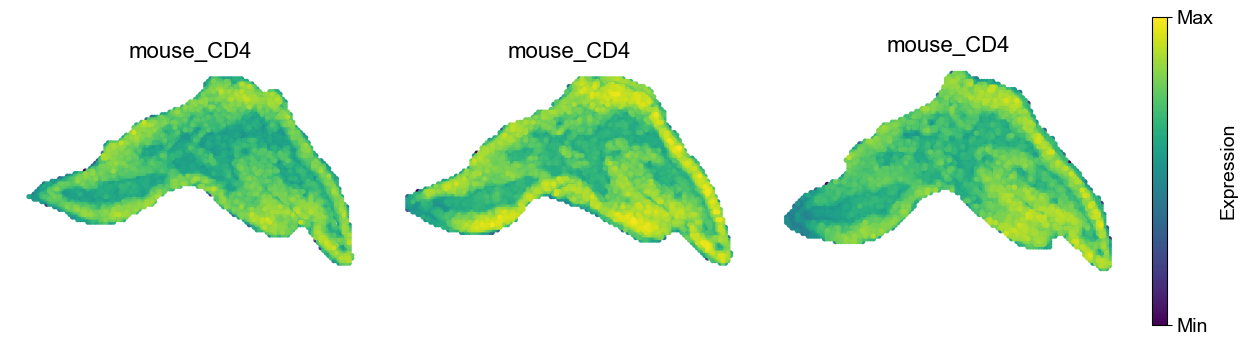

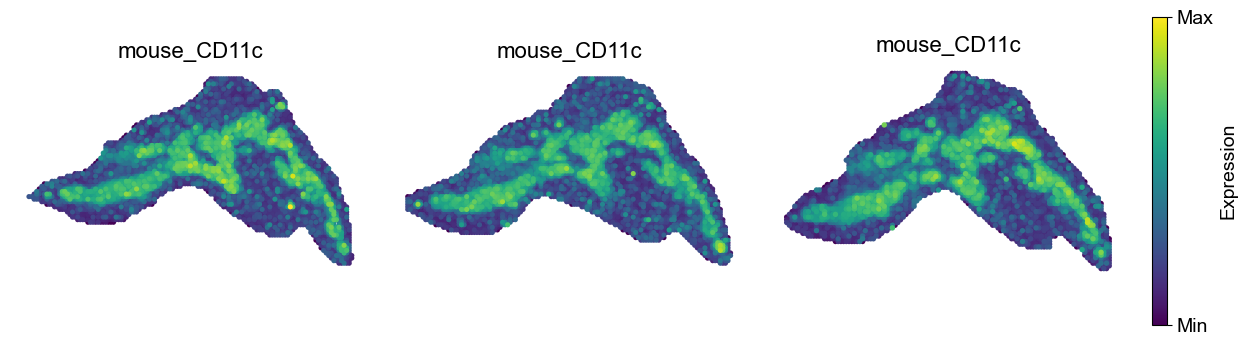

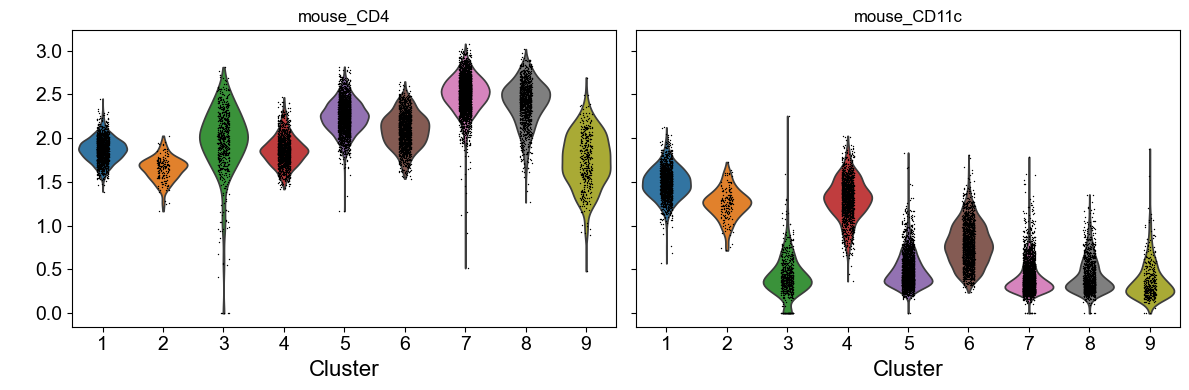

In [ ]:
def plot_spatial_expression_multi_genes(adata_list,genes,n_slices=2,slice_names=None,spot_size=100,cmap=None):
    """
    Plot spatial expression of multiple genes across multiple slices
    with a shared colorbar.
    """

    if slice_names is None:
        slice_names = [f"section_{i+1}" for i in range(n_slices)]

    vmin = min(
        adata_list[s][:, g].X.min()
        for g in genes
        for s in range(n_slices)
    )
    vmax = max(
        adata_list[s][:, g].X.max()
        for g in genes
        for s in range(n_slices)
    )

    fig, axes = plt.subplots(1, len(slice_ids), figsize=(15, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
    axes = np.atleast_1d(axes)
    mappable = None

    for gi, gene in enumerate(genes):
        for si in range(n_slices):
            idx = gi * n_slices + si
            ax = axes[idx]
            sc_ax = sc.pl.spatial(adata_list[si],color=gene,ax=ax,
                show=False,colorbar_loc=None,vmin=vmin,vmax=vmax,spot_size=spot_size,cmap=cmap)
            # 记录一个 mappable，用于共享 colorbar
            if mappable is None:
                mappable = ax.collections[0]
            ax.set_title(f"{gene}", fontsize=16)
            ax.set_axis_off()

    # colorbar
    cbar = fig.colorbar(mappable,ax=axes,location='right',fraction=0.018,shrink=0.8,pad=0.02)
    cbar.set_label('Expression', fontsize=14)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels(['Min', 'Max'])
    cbar.ax.tick_params(labelsize=14)
    plt.show()
    plt.close()

gene_list=['mouse_CD4','mouse_CD11c']
for gene in gene_list:
    genes=[gene]
    plot_spatial_expression_multi_genes(
        adata_list=adata_list,
        genes=genes,
        n_slices=3,
        slice_names=['Mouse_thymus_1','Mouse_thymus_2','Mouse_thymus_3'],
        spot_size=200
    )
    plt.close()
adata_concat.obs['mclust'] = adata_concat.obs['mclust'].astype(str).astype('category')
fig, axes = plt.subplots(1, len(gene_list), figsize=(12, 4), sharey=True)
for i, gene in enumerate(gene_list):
    sc.pl.violin(
        adata_concat,
        keys=gene,
        groupby='mclust',
        ax=axes[i],
        show=False
    )
    axes[i].set_title(gene)
    axes[i].set_xlabel("Cluster",fontsize=16)
    axes[i].tick_params(axis='both', labelsize=14)
    axes[i].set_ylabel(" ", fontsize=16)
plt.tight_layout()
plt.show()
plt.close()